# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Information Content of Trades

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [Initialize](#Initialize)
- [Information Content of Trades](#Information-Content-of-Trades)
- [Hasbrouck VAR Model](#Hasbrouck-VAR-Model)
- [Lee-Ready](#Lee-Ready)
- [Hasbrouck VAR Example](#Hasbrouck-VAR-Example)
- [Impulse Response](#Impulse-Response)
- [Further Information](#Further-Information)

# Initialize
- Initialize the number of rows and columns displayed
- Create NYSE Daily TAQ Kdb+ database connection handle `h`
- Define the table to dataframe function `tab2df`
- Import required python libraries
- Set plotting defaults
- If you haven't done so already, make sure to install the
  'statsmodels' package

```
conda install statsmodels
```

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
\c 25 120
/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5000:",first read0 upf

`:/Users/nick/cmu_userpass.txt


In [3]:
%%py
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]


# Information Content of Trades
- [Measuring the Information Content of Stock Trades - Hasbrouck (1991a)](https://www.jstor.org/stable/2328693)
- Assume a specialist market where a **single market maker** posts bid/ask
  quotes
- **Trades** result from both **public and private** information
- Anticipated **trades** result incorporate **public** information
- Unanticipated **trades** result from **private** information
- The market maker modifies its quotes to reflect this information
- **Price** changes occur because of lagged trade effects, **new trade
  innovations** and **public** information
- **Private** information can only be inferred from the **unanticipated
  trading volume**
- Using *signed* trade quantities and mid price movements, we can
  model this interaction
- Once again, we use the Lee-Ready (LR) algorithm to *estimate* the
  side of each transaction
- To extract the **anticipated** information we use a Vector
  Autoregression (VAR) model


# Hasbrouck VAR Model
- The price (mid point) change is a function of prior price changes and signed trade quantities
$$
r_t = a_1r_{t-1} + a_2r_{t-2} + \dotsb + b_0x_t + b_1x_{t-1} + \dotsb + v_{1,t}
$$
- The signed trade quantity is a function of prior signed trade quantities and price changes
$$
x_t = c_1r_{t-1} + c_2r_{t-2} + \dotsb + d_1x_{t-1} + d_2x_{t-2} + \dotsb + v_{2,t}
$$
- where $ x_t $ is the signed volume
- and $ r_t $ is the change in mid price based on bid/ask quotes
$$
r_t = (q_t^b + q_t^a)/2 - (q_{t-1}^b + q_{t-1}^a)/2
$$
- with the assumption that $v_{1,t}$ and $v_{2,t}$ have zero mean and are jointly and serially uncorrelated
$$
\mathbb{E} v_{1,t} = \mathbb{E} v_{2,t} = 0 \quad \mathrm{and} \quad  \mathbb{E} v_{1,t}v_{1,s} = \mathbb{E} v_{2,t}v_{2,s} = \mathbb{E} v_{1,t}v_{2,s} = 0
$$
- $a_i$ reflects the serial correlation in quote revisions
- $b_i$ reflects the price impact of trades
- $v_{1,t}$ reflects the innovation of public information
- $c_i$ reflects the effect of lagged quotes on trade quantities
- $d_i$ reflects the serial correlation in trade quantities
- $v_{2,t}$ reflects the innovation of private information

# Habrouck VAR Model Observations
- The price impact of trades can be estimated with $\sum_{i=0}^nb_i$
- Using actual signed volumes results in highly variable results
- A simpler approach is to use the sign of the trade with values -1
  for sells, 0 for no trade and 1 for buys
- One can alternatively use returns instead of changes in mid price
$$
r_t = \ln{(q_t^b + q_t^a)/2} - \ln{(q_{t-1}^b + q_{t-1}^a)/2}
$$

# Lee-Ready
- Implement `lr` function to accept a list of syms and a **single**
  date
- No need to filter on anything other than `date` from the `nbbo`
  table
- Reduce the network traffic by only returning the number of buy and
  sell trades per date/symbol
- Include the `date` column in the returned table so it can be merged
  with the other results


In [4]:
lr:{[s;dt]
 t:select date,sym,time,price,size from trade where date=dt,sym = s,null cond;
 t:aj[`sym`time;t]select sym,time,bid,ask from nbbo where date=dt;
 t:update mid:.5*ask+bid,tick:fills -1 0N 1@1+signum deltas[first price;price] from t;
 t:update ret:log ratios[first mid;mid] from t;
 t:update side:?[price>mid;1;?[price<mid;-1;tick]] from t;
 t}

In [5]:
10#t:h(lr;`CROX;2020.02.03)
.pykx.set[`t] .pykx.topd  `side`ret#t

date       sym  time                 price   size bid   ask   mid    tick ret           side
--------------------------------------------------------------------------------------------
2020.02.03 CROX 0D09:30:02.698013413 37.82   100  37.72 37.91 37.815      0             1   
2020.02.03 CROX 0D09:30:03.092632428 37.91   310  37.71 37.91 37.81  1    -0.0001322314 1   
2020.02.03 CROX 0D09:30:03.092634779 37.91   115  37.71 37.91 37.81  1    0             1   
2020.02.03 CROX 0D09:30:03.092638610 37.91   425  37.71 37.96 37.835 1    0.0006609822  1   
2020.02.03 CROX 0D09:30:03.792272497 37.72   190  37.72 37.96 37.84  -1   0.000132144   -1  
2020.02.03 CROX 0D09:30:05.611827273 37.72   239  37.72 37.96 37.84  -1   0             -1  
2020.02.03 CROX 0D09:30:10.426731798 37.8361 255  37.72 37.96 37.84  1    0             -1  
2020.02.03 CROX 0D09:30:52.374055570 37.84   100  37.73 37.95 37.84  1    0             1   
2020.02.03 CROX 0D09:31:50.996369655 37.94   100  37.79 37.95 37.87  1

# Hasbrouck VAR Example
- VARMAX : Vector Autoregressive Moving Average with eXogenous
  regressors model
- Setting order to (p,q) defines a model with p AR lags and q MA lags
- Setting trend = 'c' indicates a constant (no time-dependent trend)

In [6]:
%%py
mod = sm.tsa.VARMAX(t,order=(10,0),trend='c')
res = mod.fit(maxiter=5,disp=False)
print(res.summary())

/Users/nick/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Statespace Model Results                           
Dep. Variable:        ['side', 'ret']   No. Observations:                 3622
Model:                        VAR(10)   Log Likelihood               19923.928
                          + intercept   AIC                         -39757.857
Date:                Tue, 04 Nov 2025   BIC                         -39479.092
Time:                        20:41:06   HQIC                        -39658.542
Sample:                             0                                         
                               - 3622                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):     260.35, 17827.28
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.88, 0.13   Skew:                       0.14, 0.18
Prob(H) (two-sided):            0.03,

# Impulse Response
- The VARMAX model object allows us to shock an input and see the
  predictions of each output
- In our case we can shock the trade side or the return and see the
  predicted trade side and returns
- The shock is always of 'unit' (1) length

## Shock side +1 (i.e. new buy)
- Followed by smaller buys and price jump that slowly backs off
- Notice the scaling of the returns (1e-6) which corresponds to the
  purchase of single share


[Text(0.5, 1.0, 'Responses to a shock to `side`')]

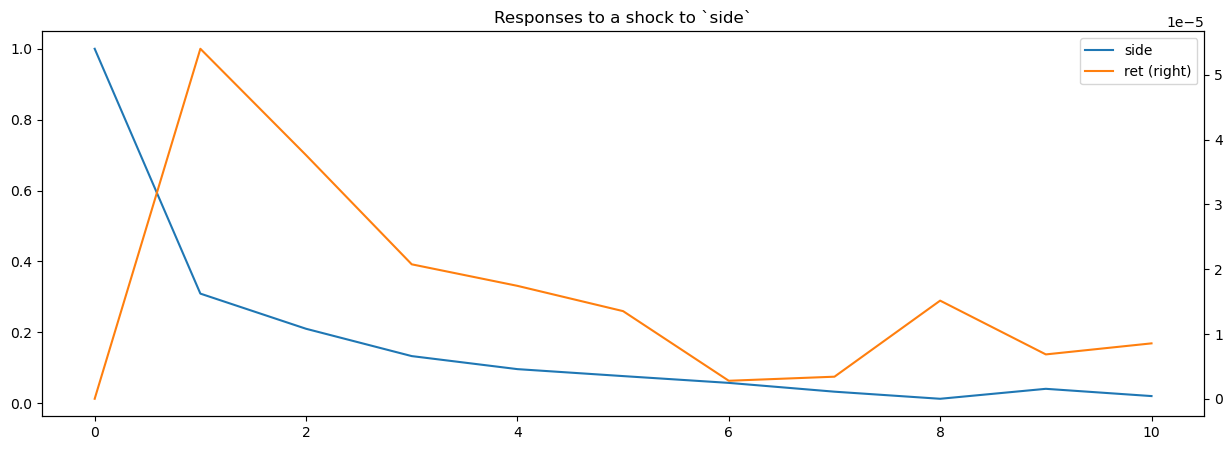

In [7]:
%%py
impulse=res.impulse_responses(10,impulse='side',orthogonalized=False,cumulative=False)
ax = impulse.plot(secondary_y='ret')
ax.set(title='Responses to a shock to `side`')


## Shock return +1
- Results in a subsequent jump in return followed by a partial reversion
  in price and short-term acceleration of buy trades
- Notice the large sell quantities which are a result of 100% return
  shock (clearly very large, but the model is linear so you can scale
  it down)


[Text(0.5, 1.0, 'Responses to a shock to `ret`')]

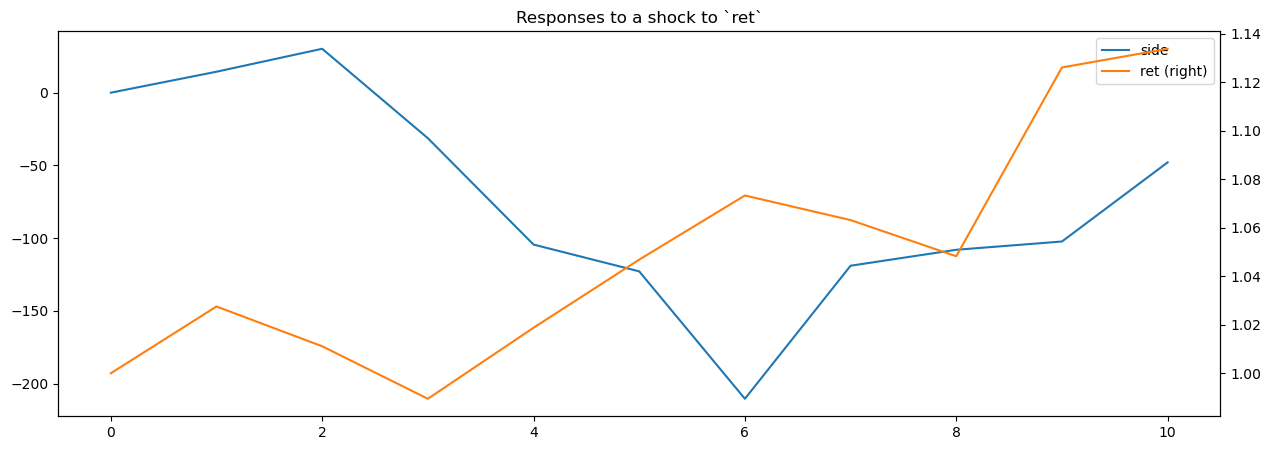

In [8]:
%%py
impulse = res.impulse_responses(10,impulse='ret',orthogonalized=False,cumulative=True)
ax = impulse.plot(secondary_y='ret')
ax.set(title='Responses to a shock to `ret`')


# Further Information
- [Empirical Market Microstructure (Joel Hasbrouck)](http://pages.stern.nyu.edu/~jhasbrou/EMM%20Book/EMM%20Home.htm)
- [SAS implementation of Hasbrouck's VAR Model](http://pages.stern.nyu.edu/~jhasbrou/EMM%20Book/SAS%20Programs%20and%20Data/Description.html)